# Sharing your own processes

Once you have created a nice algorithm or workflow in openEO, you may want to share it with other users or provide the results generated by it.
This notebook discusses some of the possibilities to do that.

To get started, we first need an example of a process that we may want to share. In this example, we'll use a simple NDVI process.

Let's first connect with an openEO backend:


In [1]:
import openeo
connection = openeo.connect("https://openeo.vito.be")
connection.authenticate_basic()

<Connection to 'https://openeo.vito.be/openeo/1.0/' with BearerAuth>

Now comes the actual algorithm that we want to share:

In [2]:
bbox = {
        "west": 6.8371137, "south": 50.560007,
        "east": 6.8566699, "north": 50.5647147,
        "crs": "EPSG:4326"
    }
cube = connection.load_collection("TERRASCOPE_S2_TOC_V2",bands=['B04','B08'])\
    .filter_temporal("2017-10-10", "2017-10-30")\
    .filter_bbox(**bbox)

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (red + nir)

And we can download and plot a result:

In [3]:
ndvi_bytes = ndvi.download( format="GTIFF")

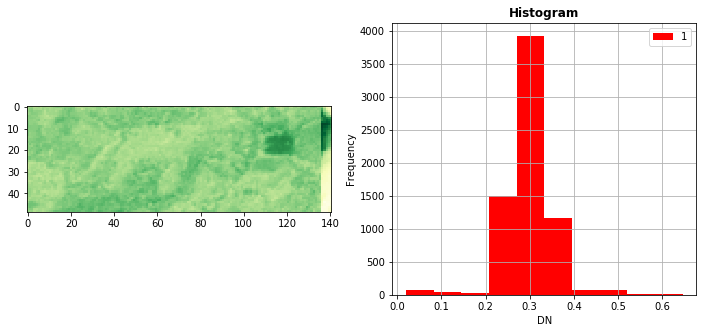

In [4]:
from rasterio.io import MemoryFile
def plot_result(data):
    with MemoryFile(data) as memfile:
        with memfile.open() as dataset:
            data_array = dataset.read()
        from rasterio.plot import show,show_hist
        import matplotlib.pyplot as plt
        fig, (l, r) = plt.subplots(1, 2,figsize=(12, 5))
        show(data_array,cmap='YlGn',ax=l)
        show_hist(data_array,ax=r)
plot_result(ndvi_bytes)

## Sharing as code
The most trivial way to share your process is to simply share the above code as open source. This has some well known advantages, but there are some downsides:
- Users that depend on a copy of your code will not get updates automatically
- The Python code can not be used in the context of a web application

This brings us to a second approach.
## Sharing the process graph
 
The code above can in fact be converted into a 'JSON' representation that describes your algorithm. This json represent an openEO 'process graph'.
https://openeo.org/documentation/1.0/developers/api/reference.html#section/Processes/Process-Graphs

The cell below shows how to do show the underlying process graph for our algorithm:

In [5]:
#to generate a string that can be saved to a file:
json_string = ndvi.to_json()

#for visualizing the process graph in Jupyter notebook
from IPython.display import JSON
JSON(ndvi.flatten())

<IPython.core.display.JSON object>

This process graph can be sent to an openEO backend to generate a result for our algorithm. So this is already more usable in the context of a web application. 
It does not however solve the problem of applying updates: multiply copies of this graph are not easily manageable. This brings us to the most advanced way of sharing your process.

## Publishing your custom process

An openEO backend allows you to publish and store a process you've created. By doing so, you effectively add a new process to the backend. By default, this process is only visible to yourself, but we also want to allow other users to access it.
The code below shows how to do this:
https://open-eo.github.io/openeo-python-client/processes.html#publishing-your-process-as-a-service

The advantage of this approach that users do not need to see your full process graph, and the implementation is even hidden to a certain extent (TBD). 

<div class="alert alert-block alert-warning">
    Experimental feature: the openEO API for sharing processes with other users is still under development, so both the web service API and the Python client API are subject to change.<br/>
    Related issue: https://github.com/Open-EO/openeo-api/issues/310
</div>

In [6]:
my_saved_process = ndvi.save_user_defined_process("the_best_ndvi_ever",public=True)
my_saved_process

From now on, the process is available on the backend and can be invoked like this:

In [7]:

ndvi_bytes = connection.datacube_from_process("the_best_ndvi_ever").download( format="GTIFF")

/data/users/Public/driesj/openeo/openeo-python-client/openeo/metadata.py:210: UserWarning: No cube:dimensions metadata
  complain("No cube:dimensions metadata")


Now we want to add a parameter to our custom process, so that users can customize the output.

In [8]:
from openeo.api.process import Parameter
temporal_extent = Parameter(
        name="date", description="A date for which to compute the Sentinel-2 NDVI.",
        schema={"type": "string", "subtype": "date-time"}
    )

graph_with_parameters = ndvi.flatten()
graph_with_parameters['filtertemporal1']['arguments']['extent'][0]={'from_parameter':'date'}
graph_with_parameters['filtertemporal1']['arguments']['extent'][1]={'from_parameter':'date'}

import json
with open("my_ndvi.json","w") as outfile:
    json.dump({"process_graph":graph_with_parameters, "summary":"My NDVI process"},outfile)
JSON(graph_with_parameters)

<IPython.core.display.JSON object>

In [9]:
connection.save_user_defined_process("the_best_ndvi_ever", graph_with_parameters, parameters=[temporal_extent])

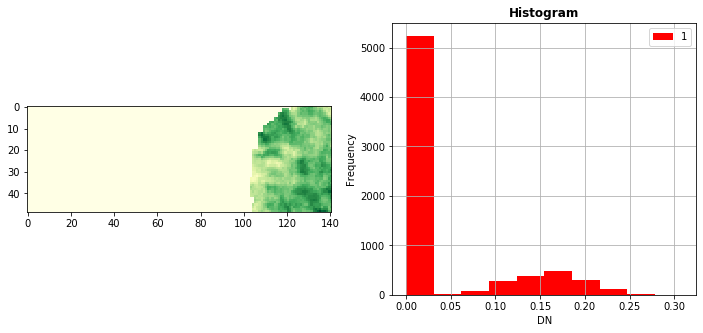

In [10]:
ndvi_for_date = connection.datacube_from_process("the_best_ndvi_ever",date="2020-01-03").download( format="GTIFF")
plot_result(ndvi_for_date)

Open the openEO editor at 'https://editor.openeo.org' and look for your new process!

### Adding more process metadata
This page:
https://openeo.org/documentation/1.0/developers/api/reference.html#operation/describe-custom-process
describes all the available process metadata.

## Example direct request

Users of the web service API can now do direct requests:

In [11]:
request = {"process":{"process_graph":{
    "ndvi_node":{
        "process_id":"the_best_ndvi_ever",
        "namespace":"https://raw.githubusercontent.com/Open-EO/openeo-python-client/master/examples/notebooks/my_ndvi.json",
        "arguments":{
            "date":"2020-01-03"
        },
        "result":True
    
}}
}}
r = connection.post(path="/result", json=request, stream=True, timeout=1000)
r.status_code

200

In [12]:
request = {"process":{"process_graph":{
    "ndvi_node":{
        "process_id":"the_best_ndvi_ever",
        "namespace":"user",
        "arguments":{
            "date":"2020-01-03"
        },
        "result":True
    
}}
}}
r = connection.post(path="/result", json=request, stream=True, timeout=1000)
r.status_code

200